In [1]:
import numpy as np
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import warnings
from itertools import product
from lmphoton.simulation import current_simulation as sim
from scipy.optimize import minimize
from vernier_ring import Ring
from sagnac_mirror import SagnacRing
from ph_ht_tr import ph_ht_tr
from soa import SOA as SOA
from scipy.constants import constants
import pandas as pd
import seaborn as sns
plt.style.use("plot_style.mplstyle")
warnings.filterwarnings("ignore")

In [2]:
um = 1e-6

no_bins = 500001

## Vernier ring design

In [3]:
_ring_1 = Ring(
    splitratio1=0.2,
    splitratio2=0.2,
    radius=25,
    waveguide_loss_rate=0.33,
    index=1
)

_ring_2 = Ring(
    splitratio1=0.2,
    splitratio2=0.2,
    radius=26.4,
    waveguide_loss_rate=0.33,
    index=2
)

_sagnac_ring = SagnacRing(
  loss = 0,
  waveguide_loss_rate=0,
  splitratio=0.5,
  index = 1
)

_ring_1_effective_length = _ring_1.get_effective_length()
_ring_2_effective_length = _ring_2.get_effective_length()
_sagnac_ring_effective_length = _sagnac_ring.get_effective_length()

print(f"Ring 1 effective length: {_ring_1_effective_length*1e6:0.3f} um,  Ring 2 effective length: {_ring_2_effective_length*1e6:0.3f} um, Sagnac effective length: {_sagnac_ring_effective_length*1e6:0.3f} um")

Ring 1 effective length: 628.319 um,  Ring 2 effective length: 663.504 um, Sagnac effective length: 251.327 um


In [4]:
def vernier_ring_tuning(phase, wavelength = 1.31e-6, verbose = False):
    """
    Objective function for tuning the vernier ring
    """

    _ring_1.wg1._init_phase = phase[0]
    _ring_2.wg2._init_phase = phase[1]
    _ring_1.recursive_update()
    _ring_2.recursive_update()
    sim().wavelength = wavelength
    _ring_1_smatrix = _ring_1.smatrix
    _ring_2_smatrix = _ring_2.smatrix

    _vernier_ring_smatrix = _ring_1_smatrix * _ring_2_smatrix

    if verbose:
        return (-np.abs(_vernier_ring_smatrix[0, 1])**2, np.abs(_ring_1_smatrix[0,1])**2, np.abs(_ring_2_smatrix[0,1])**2)
    else:
        return -np.abs(_vernier_ring_smatrix[0, 1])**2

def sagnac_ring_tuning(split_ratio = 0.707, wavelength = 1.31e-6):
    """
    Objective function for tuning the sagnac ring
    """
    _sagnac_ring.dc._splitratio = split_ratio
    _sagnac_ring.recursive_update()

    sim().wavelength = wavelength
    _sagnac_ring_smatrix = _sagnac_ring.smatrix

    return -np.abs(_sagnac_ring_smatrix[0, 0])**2

bounds = [(-np.pi, np.pi), (-np.pi, np.pi)]

opts = {
  "maxiter": 1000,
  "xatol": 1e-6,
  "fatol": 1e-6,
}

result = minimize(
    vernier_ring_tuning,
    ((0.0, 0.0)),
    bounds=bounds,
    method='Nelder-Mead',
    tol = 1e-6
    )

100%|██████████| 500001/500001 [02:29<00:00, 3350.81it/s]


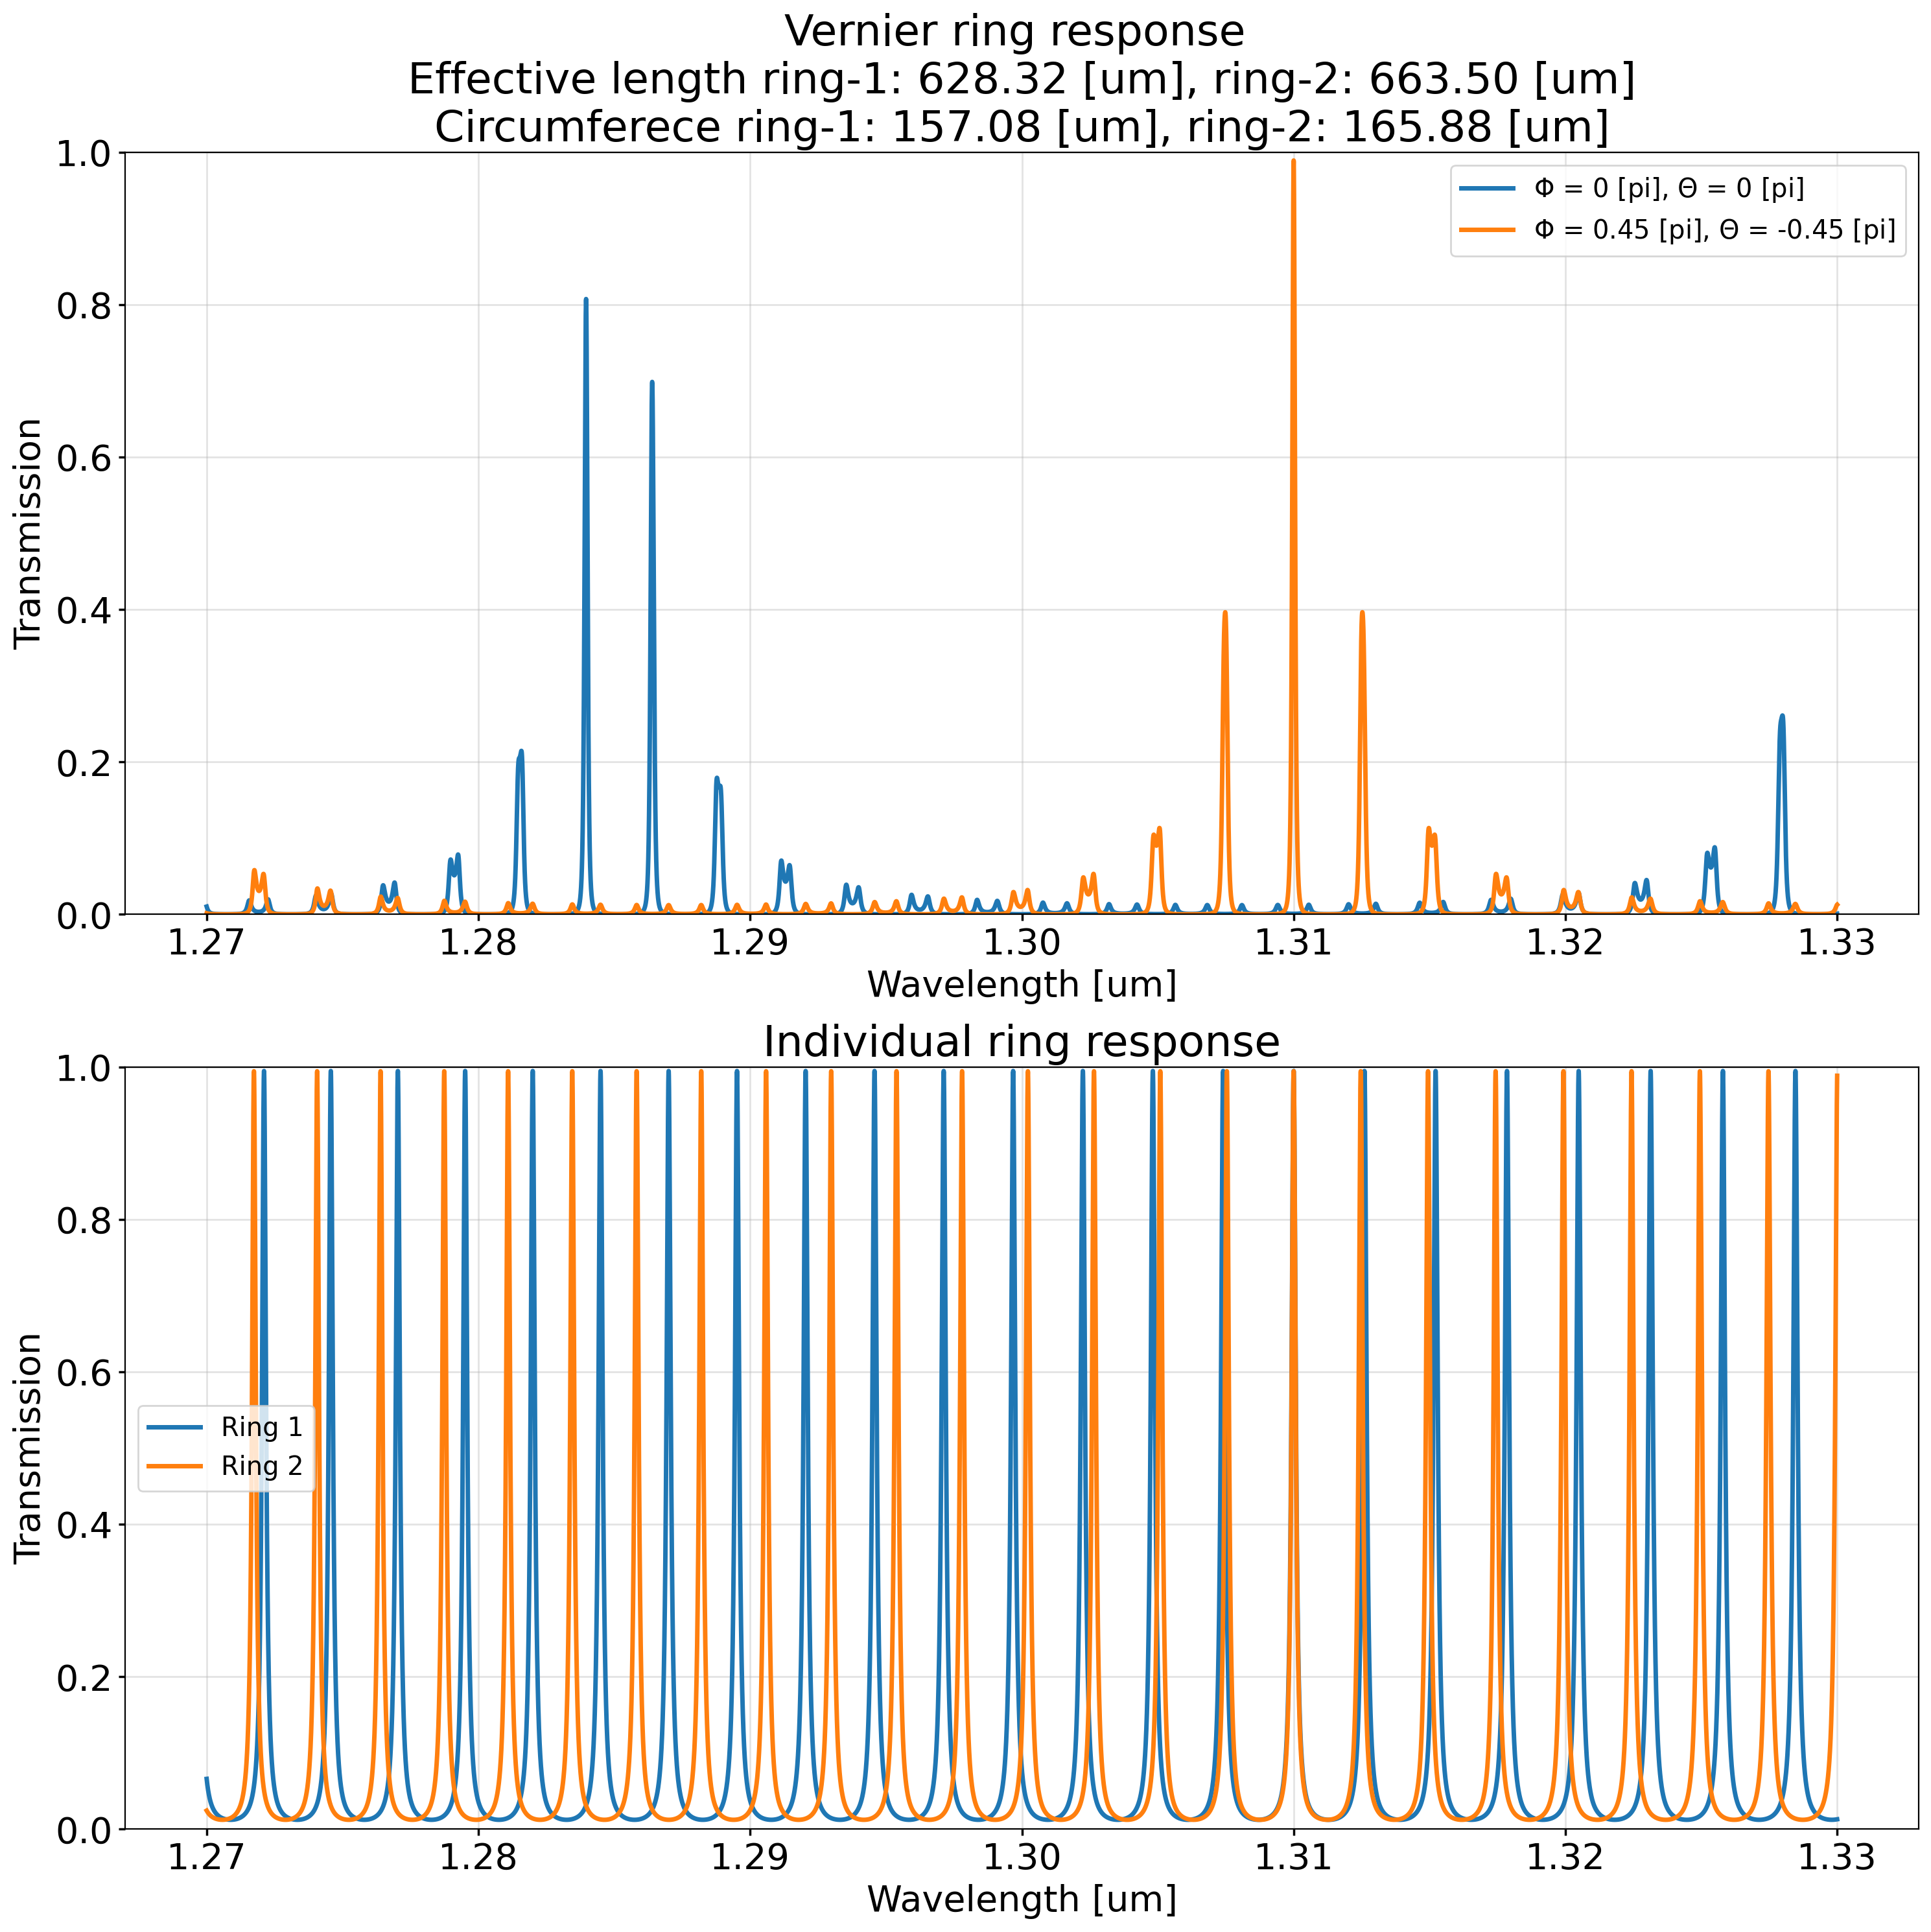

In [5]:
result.x
vernier_response_untuned = []
vernier_response_tuned = []
_ring_1_smatrix = []
_ring_2_smatrix = []

wavelengths = np.linspace(1.27, 1.33, num=no_bins) * um

for wavelength in tqdm(wavelengths):
  _vr_untuned, _ring_1_untuned, _ring_2_untuned = vernier_ring_tuning((0.0, 0.0), wavelength, verbose = True)
  vernier_response_untuned.append(_vr_untuned)
  _vr_tuned, _ring_1_tuned, _ring_2_tuned = vernier_ring_tuning((result.x[0], result.x[1]), wavelength, verbose = True)
  vernier_response_tuned.append(_vr_tuned)
  _ring_1_smatrix.append(_ring_1_tuned)
  _ring_2_smatrix.append(_ring_2_tuned)


plt.figure(figsize=(15,15))
plt.subplot(211)
plt.plot(wavelengths/um, -1*np.array(vernier_response_untuned), label=f"$\Phi$ = 0 [pi], $\Theta$ = 0 [pi]")
plt.plot(wavelengths/um, -1*np.array(vernier_response_tuned), label=f"$\Phi$ = {result.x[0]/np.pi:0.2f} [pi], $\Theta$ = {result.x[1]/np.pi:0.2f} [pi]")
plt.xlabel("Wavelength [um]")
plt.ylabel("Transmission")
plt.title("Vernier ring response " +"\n"+f"Effective length ring-1: {_ring_1.get_effective_length()*1e6:0.2f} [um], ring-2: {_ring_2.get_effective_length()*1e6:0.2f} [um]" +"\n"+f"Circumferece ring-1: {_ring_1.L_circum*1e6:0.2f} [um], ring-2: {_ring_2.L_circum*1e6:0.2f} [um]")
plt.grid(True)
plt.ylim([0,1])
plt.legend()
plt.subplot(212)
plt.plot(wavelengths/um, np.array(_ring_1_smatrix), label="Ring 1")
plt.plot(wavelengths/um, np.array(_ring_2_smatrix), label="Ring 2")
plt.grid(True)
plt.ylim([0,1])
plt.xlabel("Wavelength [um]")
plt.ylabel("Transmission")
plt.title("Individual ring response")
plt.legend()
plt.tight_layout()

## Longitudinal mode design

In [6]:
R_vrng = -1*vernier_ring_tuning((result.x[0], result.x[1]), 1.31e-6)
R_sagnac = -1*sagnac_ring_tuning(split_ratio=0.44, wavelength=1.31e-6)

T_vrng = 1 - R_vrng
T_sagnac = 1 - R_sagnac

print(f"Vernier ring reflectivity: {R_vrng:0.3f}, Sagnac ring reflectivity: {R_sagnac:0.3f}")
print(f"Vernier ring transmittivity: {T_vrng:0.3f}, Sagnac ring transmittivity: {T_sagnac:0.3f}")

Vernier ring reflectivity: 0.989, Sagnac ring reflectivity: 0.986
Vernier ring transmittivity: 0.011, Sagnac ring transmittivity: 0.014


In [7]:
def longitudinal_cavity_modes(L_soa = 1300*um, L_htr = 1300*um, L_excess = 250 * um, R_vrng = 0.9, R_sagnac=0.9, wavelength = 1.31e-6):
    """
    Calculate the longitudinal cavity modes
    """

    T_vrng = 1 - R_vrng
    T_sagnac = 1 - R_sagnac

    L_cavity = L_soa * 2 + L_htr * 2 + L_excess * 2 + _ring_1_effective_length + _ring_2_effective_length + _sagnac_ring_effective_length

    phi_offset = 2 * np.pi * L_cavity * 0.5 * 1.93 / 1.31e-6
    phi = 2 * np.pi * L_cavity * 0.5 * 1.93 / wavelength - phi_offset

    num = -1 * np.sqrt(T_vrng*T_sagnac) *  np.exp(-1j * phi)
    denom = 1 - np.sqrt(R_vrng*R_sagnac) * np.exp(-2 * 1j * phi)
    H = num/denom
    return np.real(H * np.conj(H))

100%|██████████| 500001/500001 [00:01<00:00, 313296.62it/s]


Text(0.5, 1.0, 'Longitudinal cavity modes')

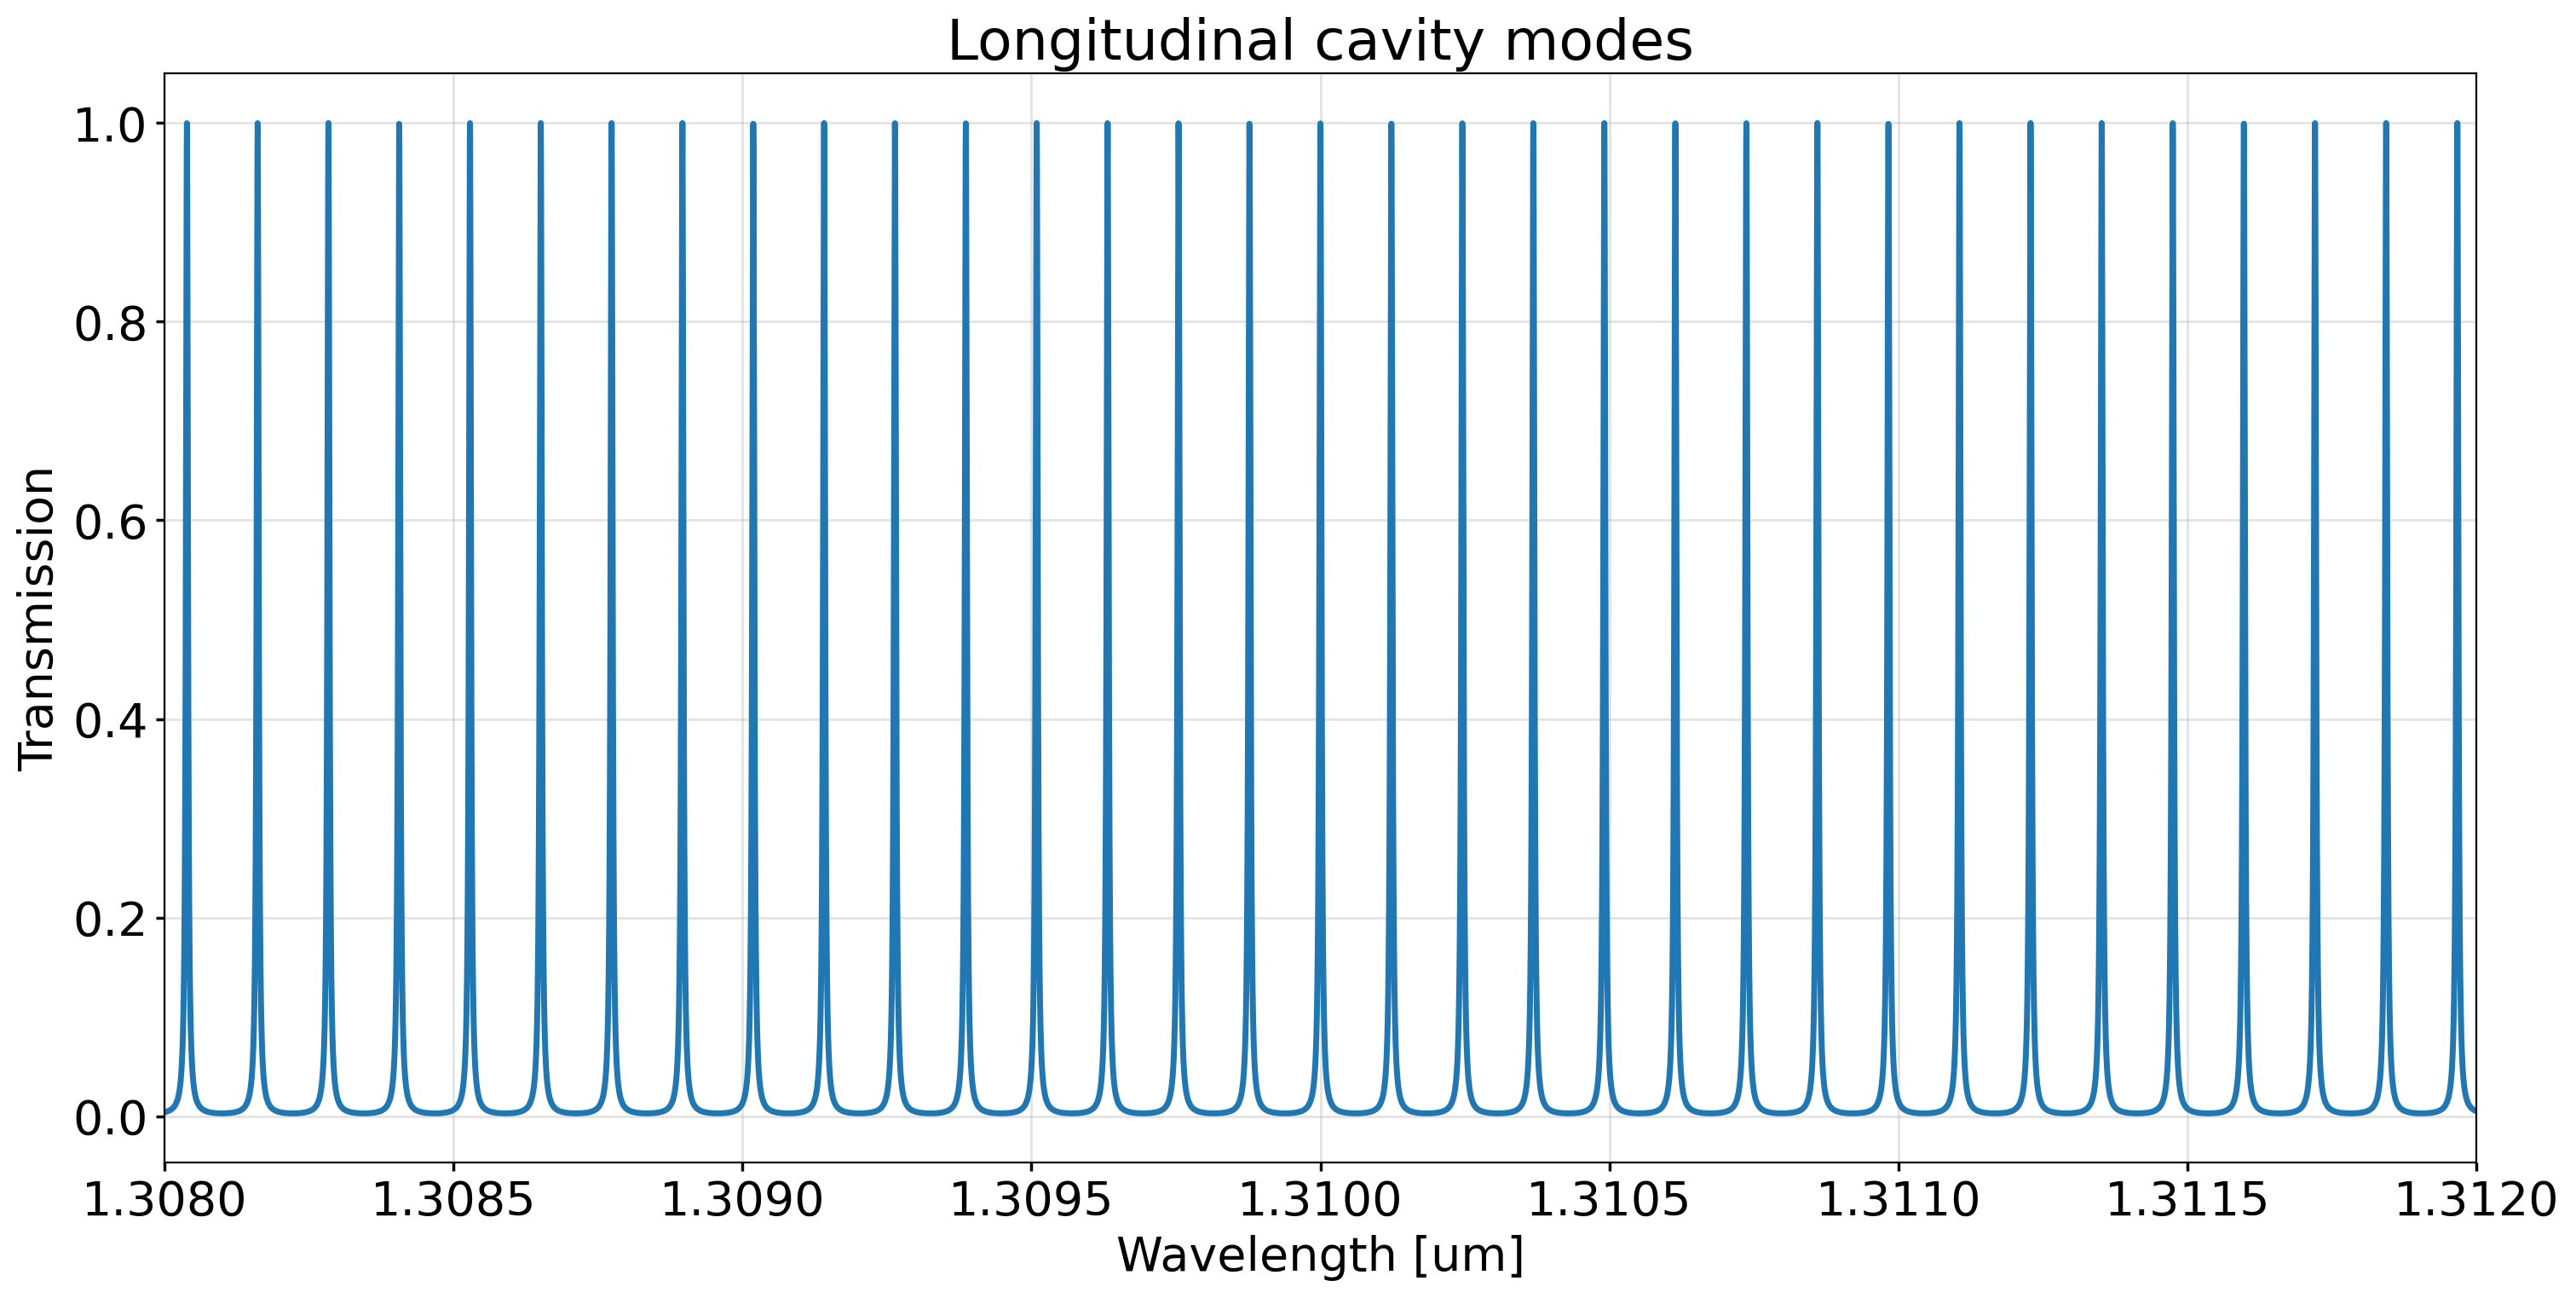

In [8]:
plt.figure(figsize=(15,7.5))
lc_modes = []
for wavelength in tqdm(wavelengths):
  lc_modes.append(longitudinal_cavity_modes(wavelength=wavelength))
plt.plot(wavelengths/um, lc_modes)
plt.xlim([1.308, 1.312])
plt.xlabel("Wavelength [um]")
plt.ylabel("Transmission")
plt.title("Longitudinal cavity modes")

In [9]:
lc_modes = np.array(lc_modes)
laser_cavity_mode = lc_modes * -1*np.array(vernier_response_tuned)

Text(0, 0.5, 'Transmission')

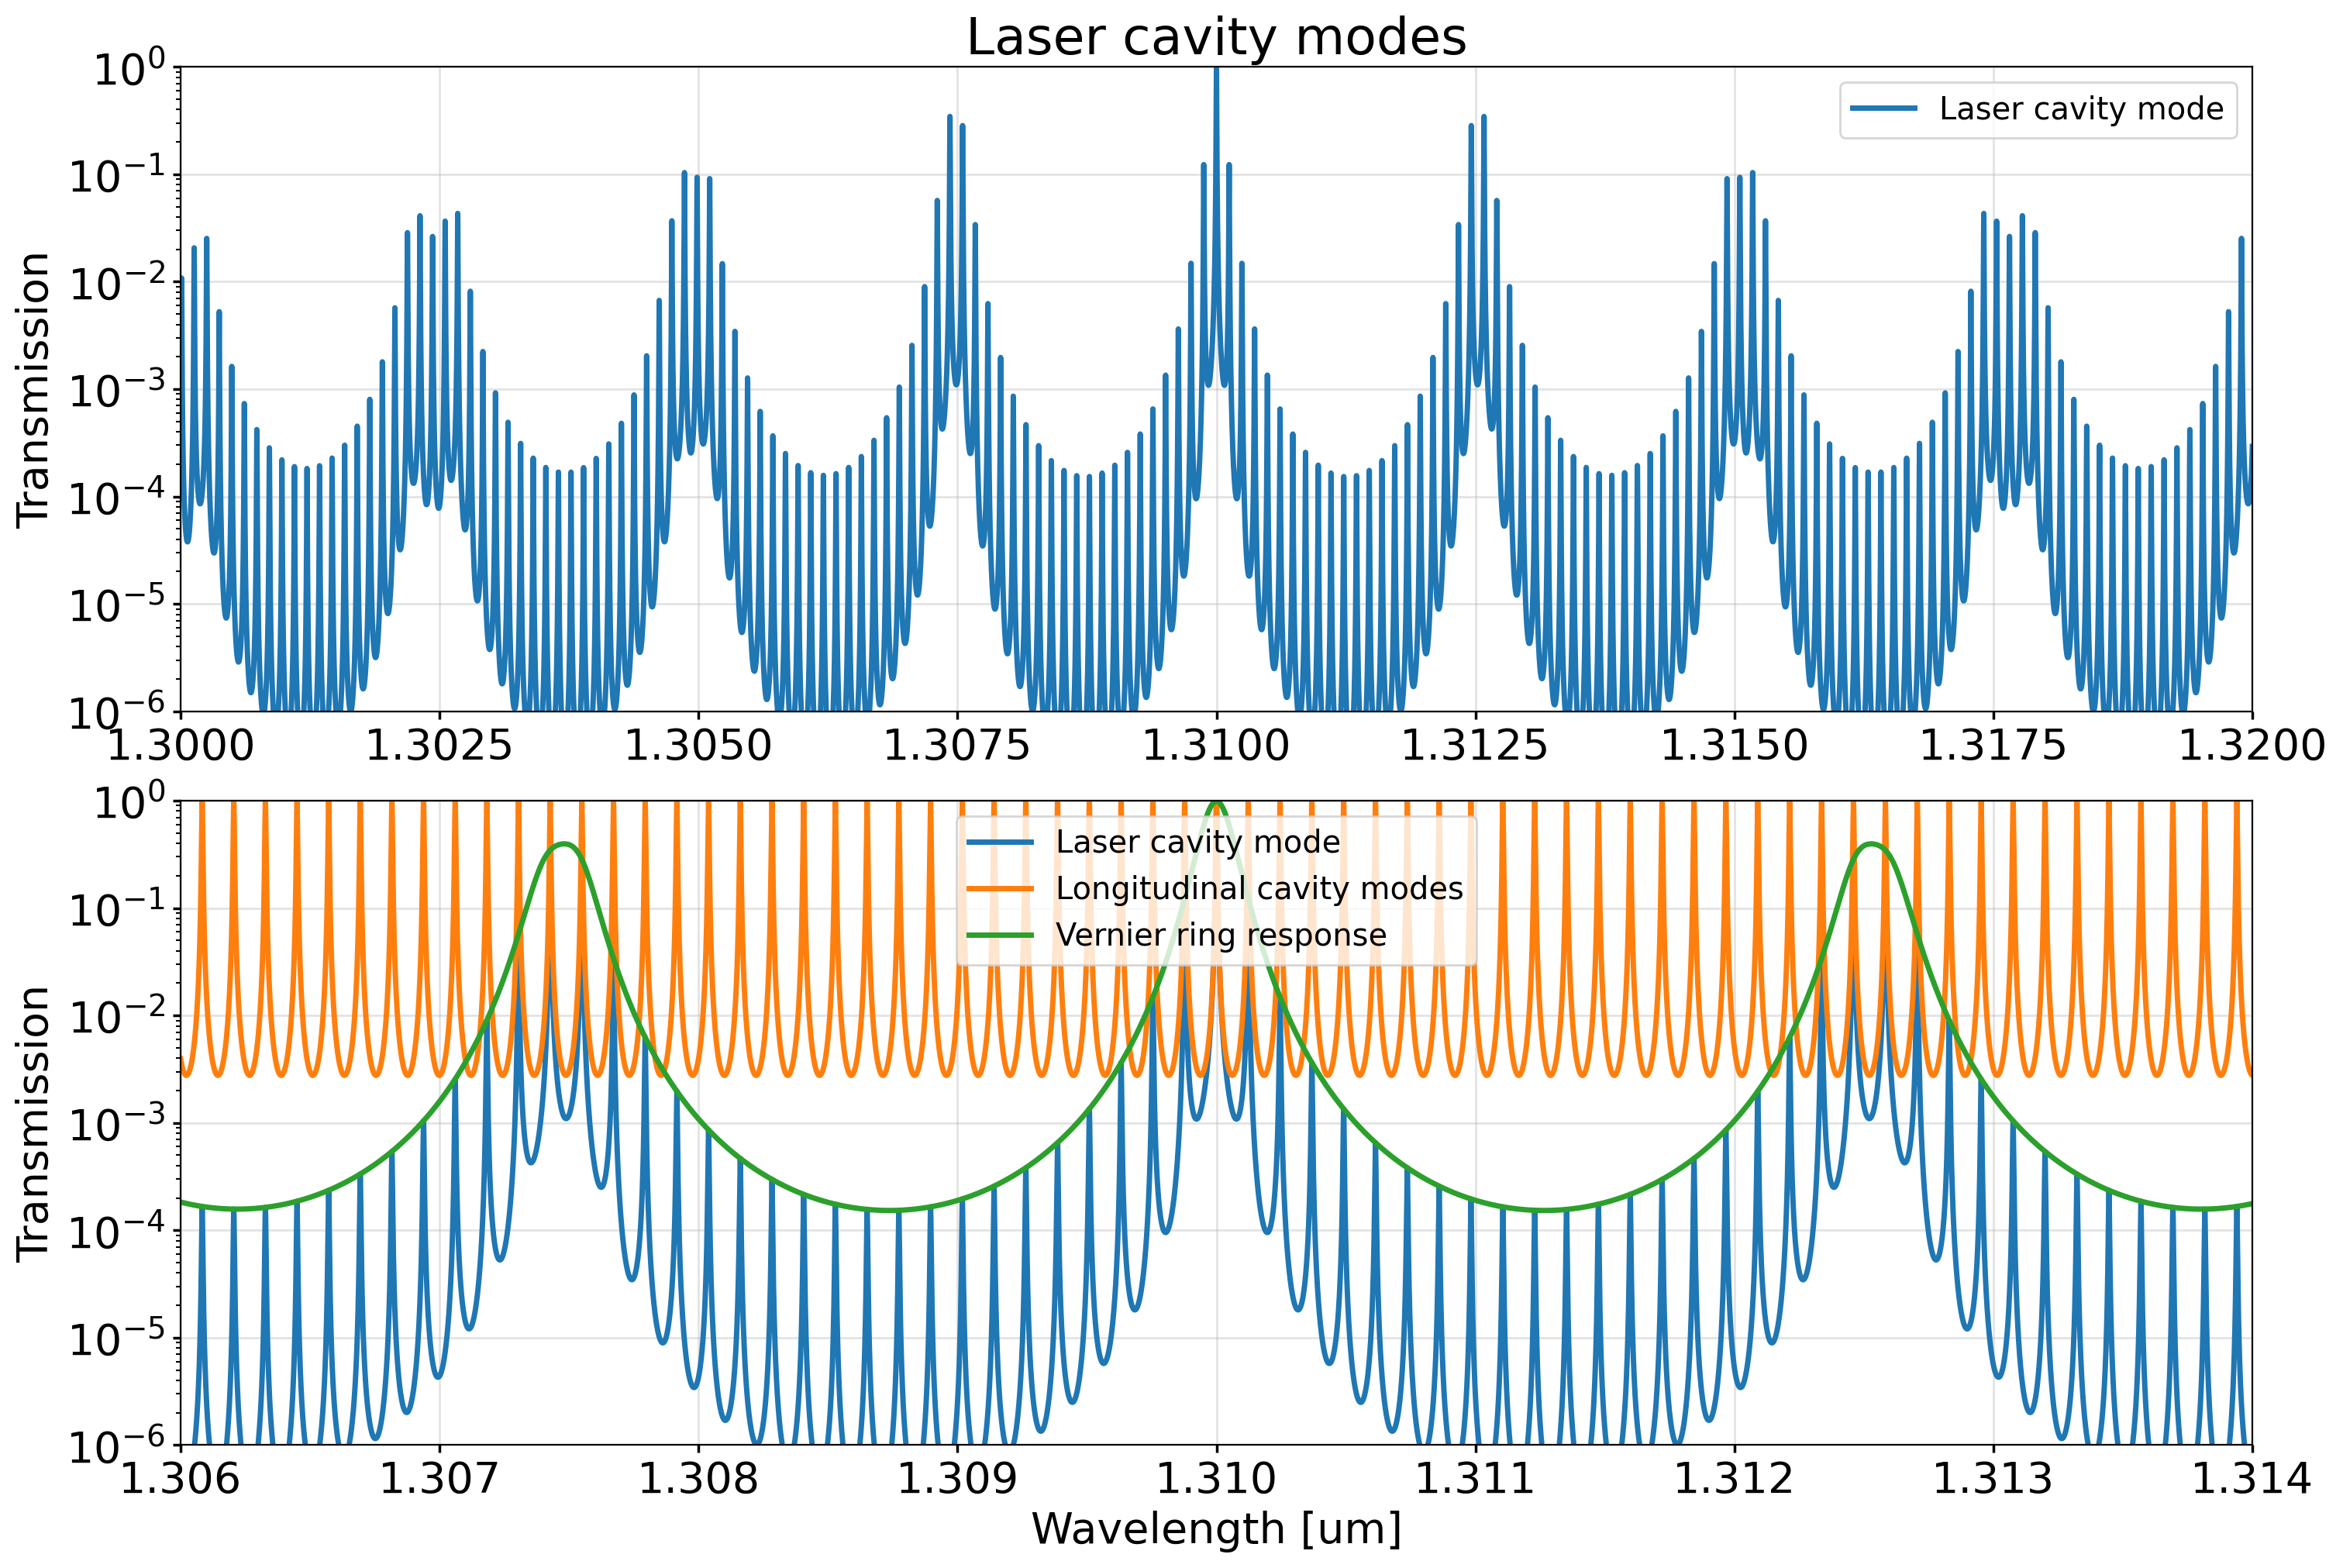

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.semilogy(wavelengths/um, laser_cavity_mode, label="Laser cavity mode")
plt.xlim([1.3, 1.32])
plt.ylim([1e-6,1])
plt.legend()
plt.ylabel("Transmission")
plt.title("Laser cavity modes")
plt.subplot(212)
plt.semilogy(wavelengths/um, laser_cavity_mode, label="Laser cavity mode")
plt.semilogy(wavelengths/um, lc_modes, label="Longitudinal cavity modes")
plt.semilogy(wavelengths/um, -1*np.array(vernier_response_tuned), label="Vernier ring response")
plt.xlim([1.306, 1.314])
plt.ylim([1e-6,1])
plt.legend()
plt.xlabel("Wavelength [um]")
plt.ylabel("Transmission")

## SOA analysis

In [11]:
L = np.array([440, 640, 790])
J = np.array([5, 7])
T = np.array([55, 65, 75, 85])
wavelengths_soa = np.linspace(1.27, 1.33, num=101) * um

g0_sweep = []
for length, current_density, temperature, wavelength in tqdm(product(L, J, T, wavelengths_soa), total=len(L)*len(J)*len(T)*len(wavelengths_soa)):
  _soa = SOA(
    temperature = temperature,
    current_density = current_density,
    length = length * um
  )
  sim().wavelength = wavelength
  _soa.recursive_update()
  _smatrix = _soa.smatrix
  g0_sweep.append(_soa._g0)
g0_sweep = np.array(g0_sweep).reshape((len(L), len(J), len(T), len(wavelengths_soa)))

100%|██████████| 2424/2424 [00:00<00:00, 4330.81it/s]


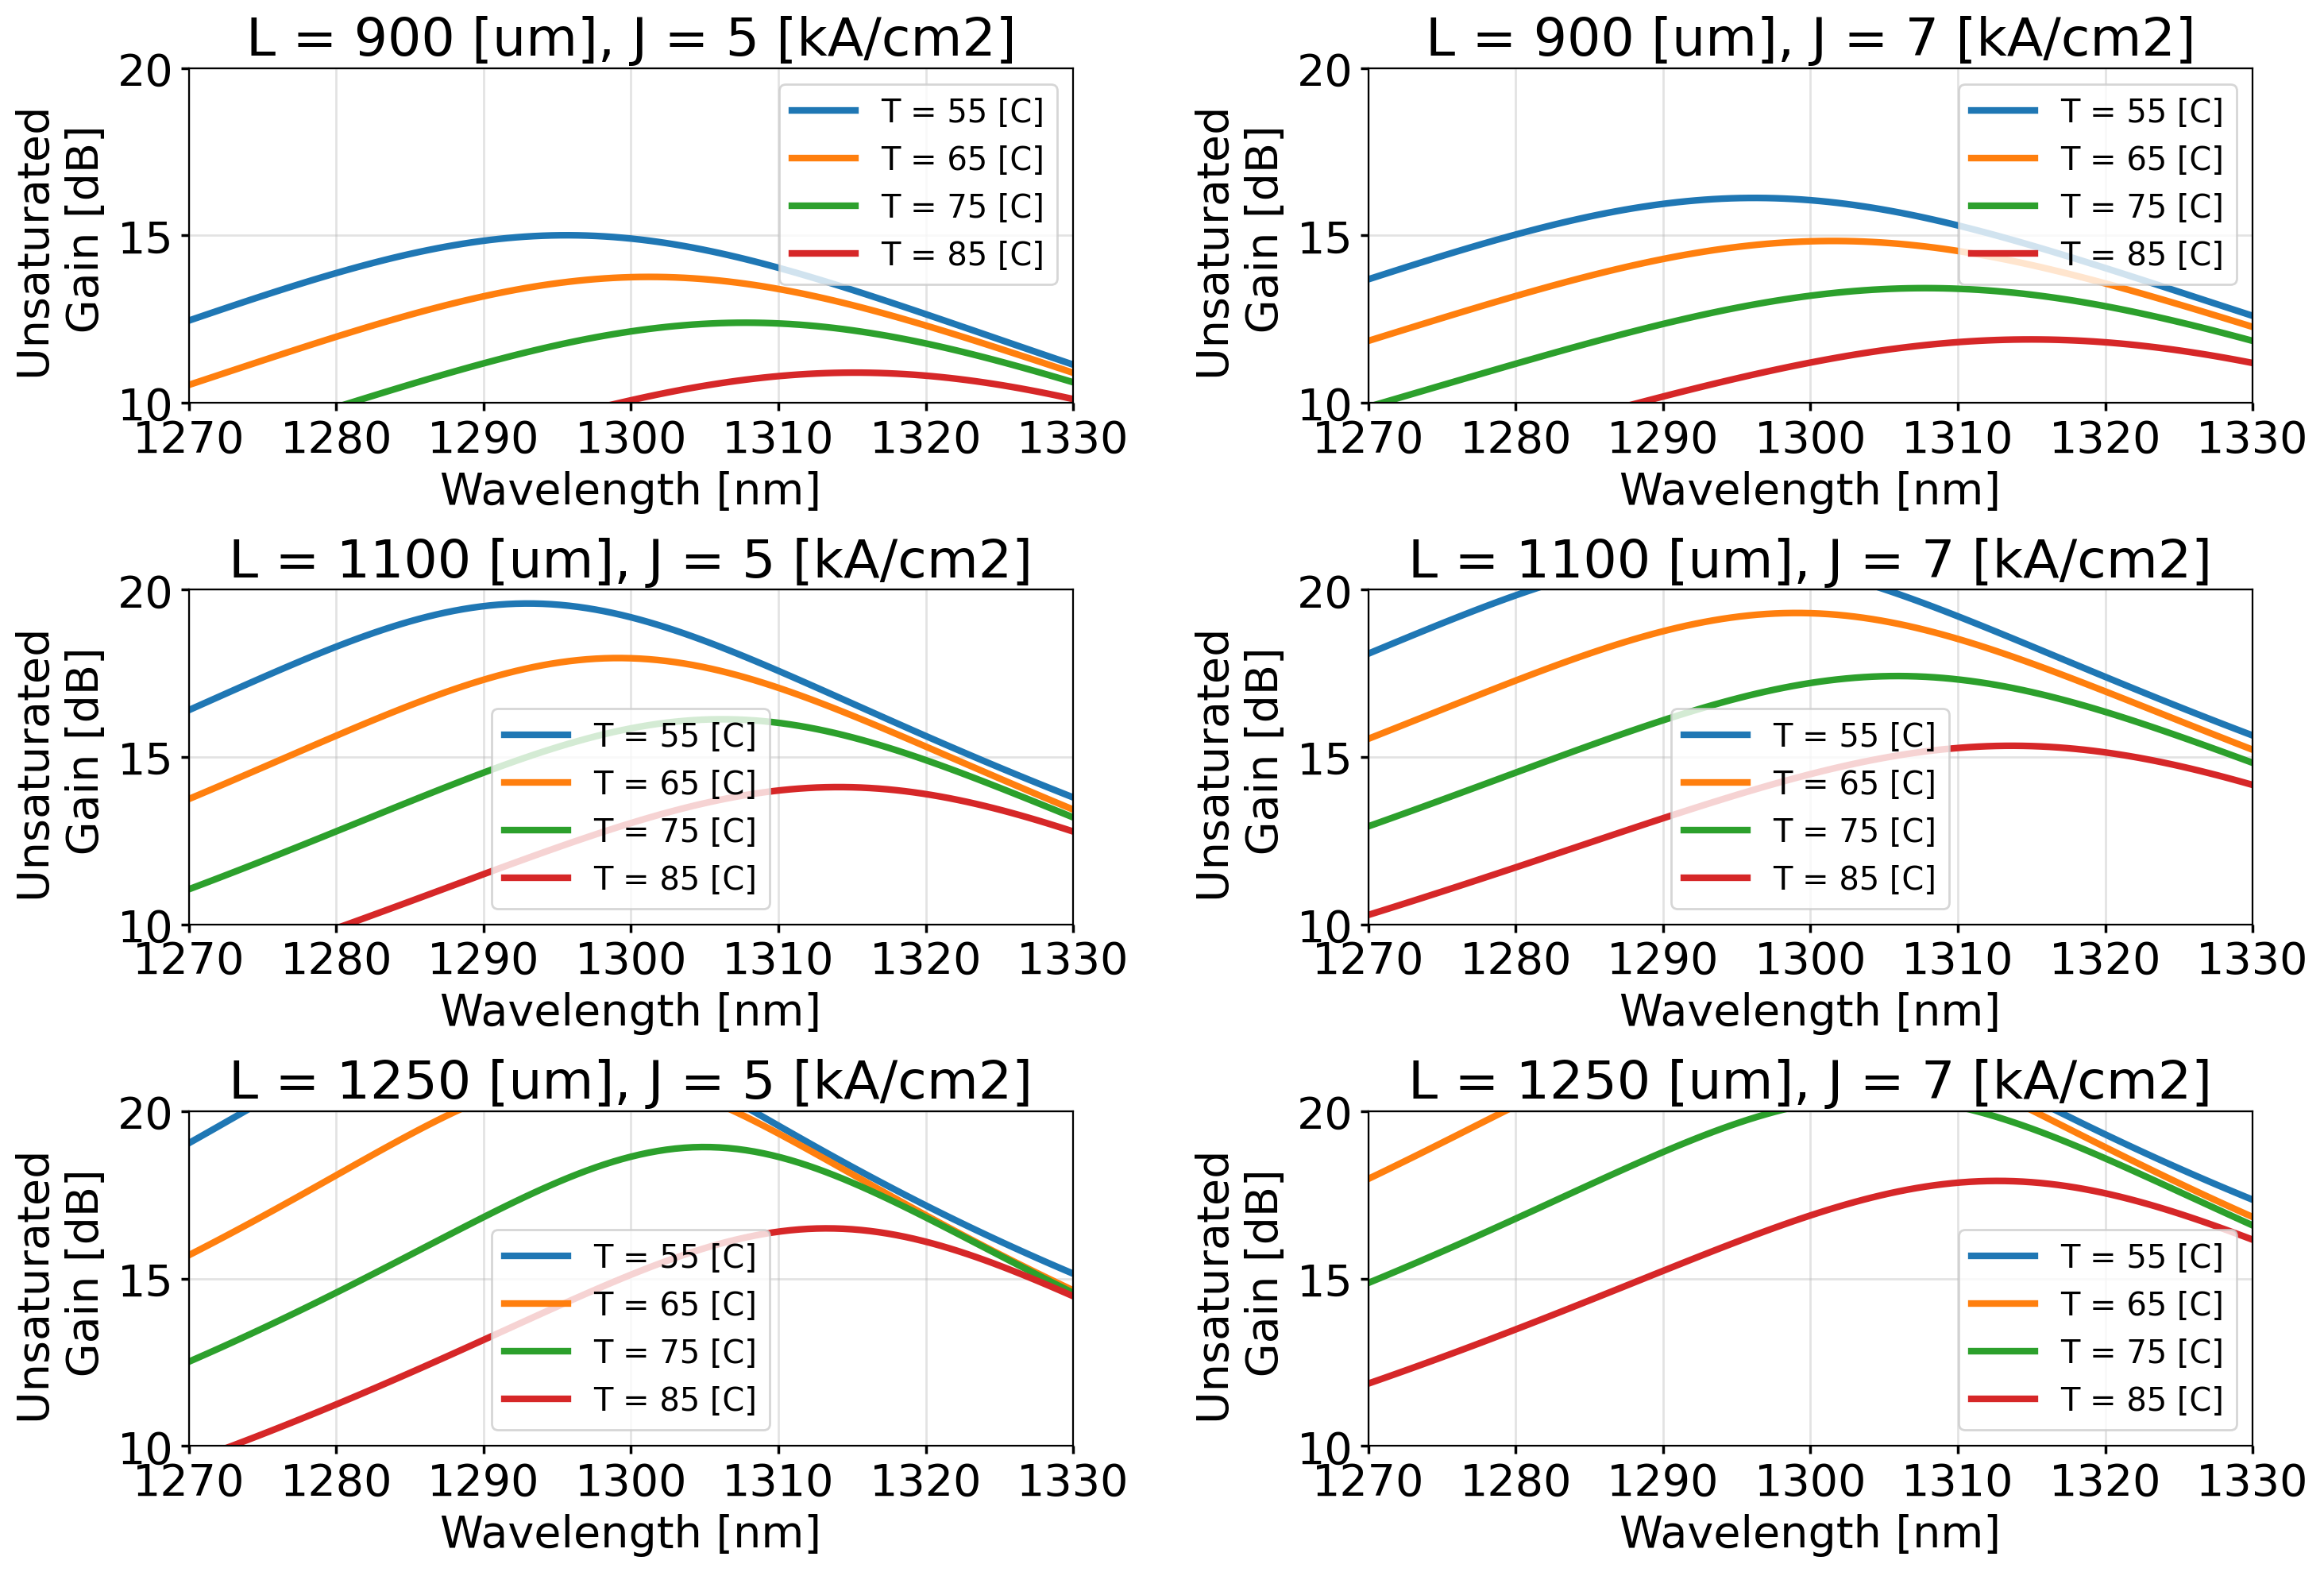

In [12]:
plt.figure(figsize=(15,10))
for idd_current_density, current_density in enumerate(J):
  for idd_length, length in enumerate(L):
    plt.subplot(len(L), len(J), idd_length*len(J)+idd_current_density+1)
    for idd_temperature, temperature in enumerate(T):  
      plt.plot(wavelengths_soa/um*1e3, 10*np.log10(g0_sweep[idd_length, idd_current_density, idd_temperature, :]), linewidth=3.0,label=f"T = {temperature} [C]")
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("Unsaturated \n Gain [dB]")
    plt.title(f"L = {length + 460} [um], J = {current_density} [kA/cm2]")
    plt.grid(True)
    plt.xlim([1270, 1330])
    plt.ylim([10, 20])
    plt.grid(True)
    plt.legend()
plt.tight_layout()

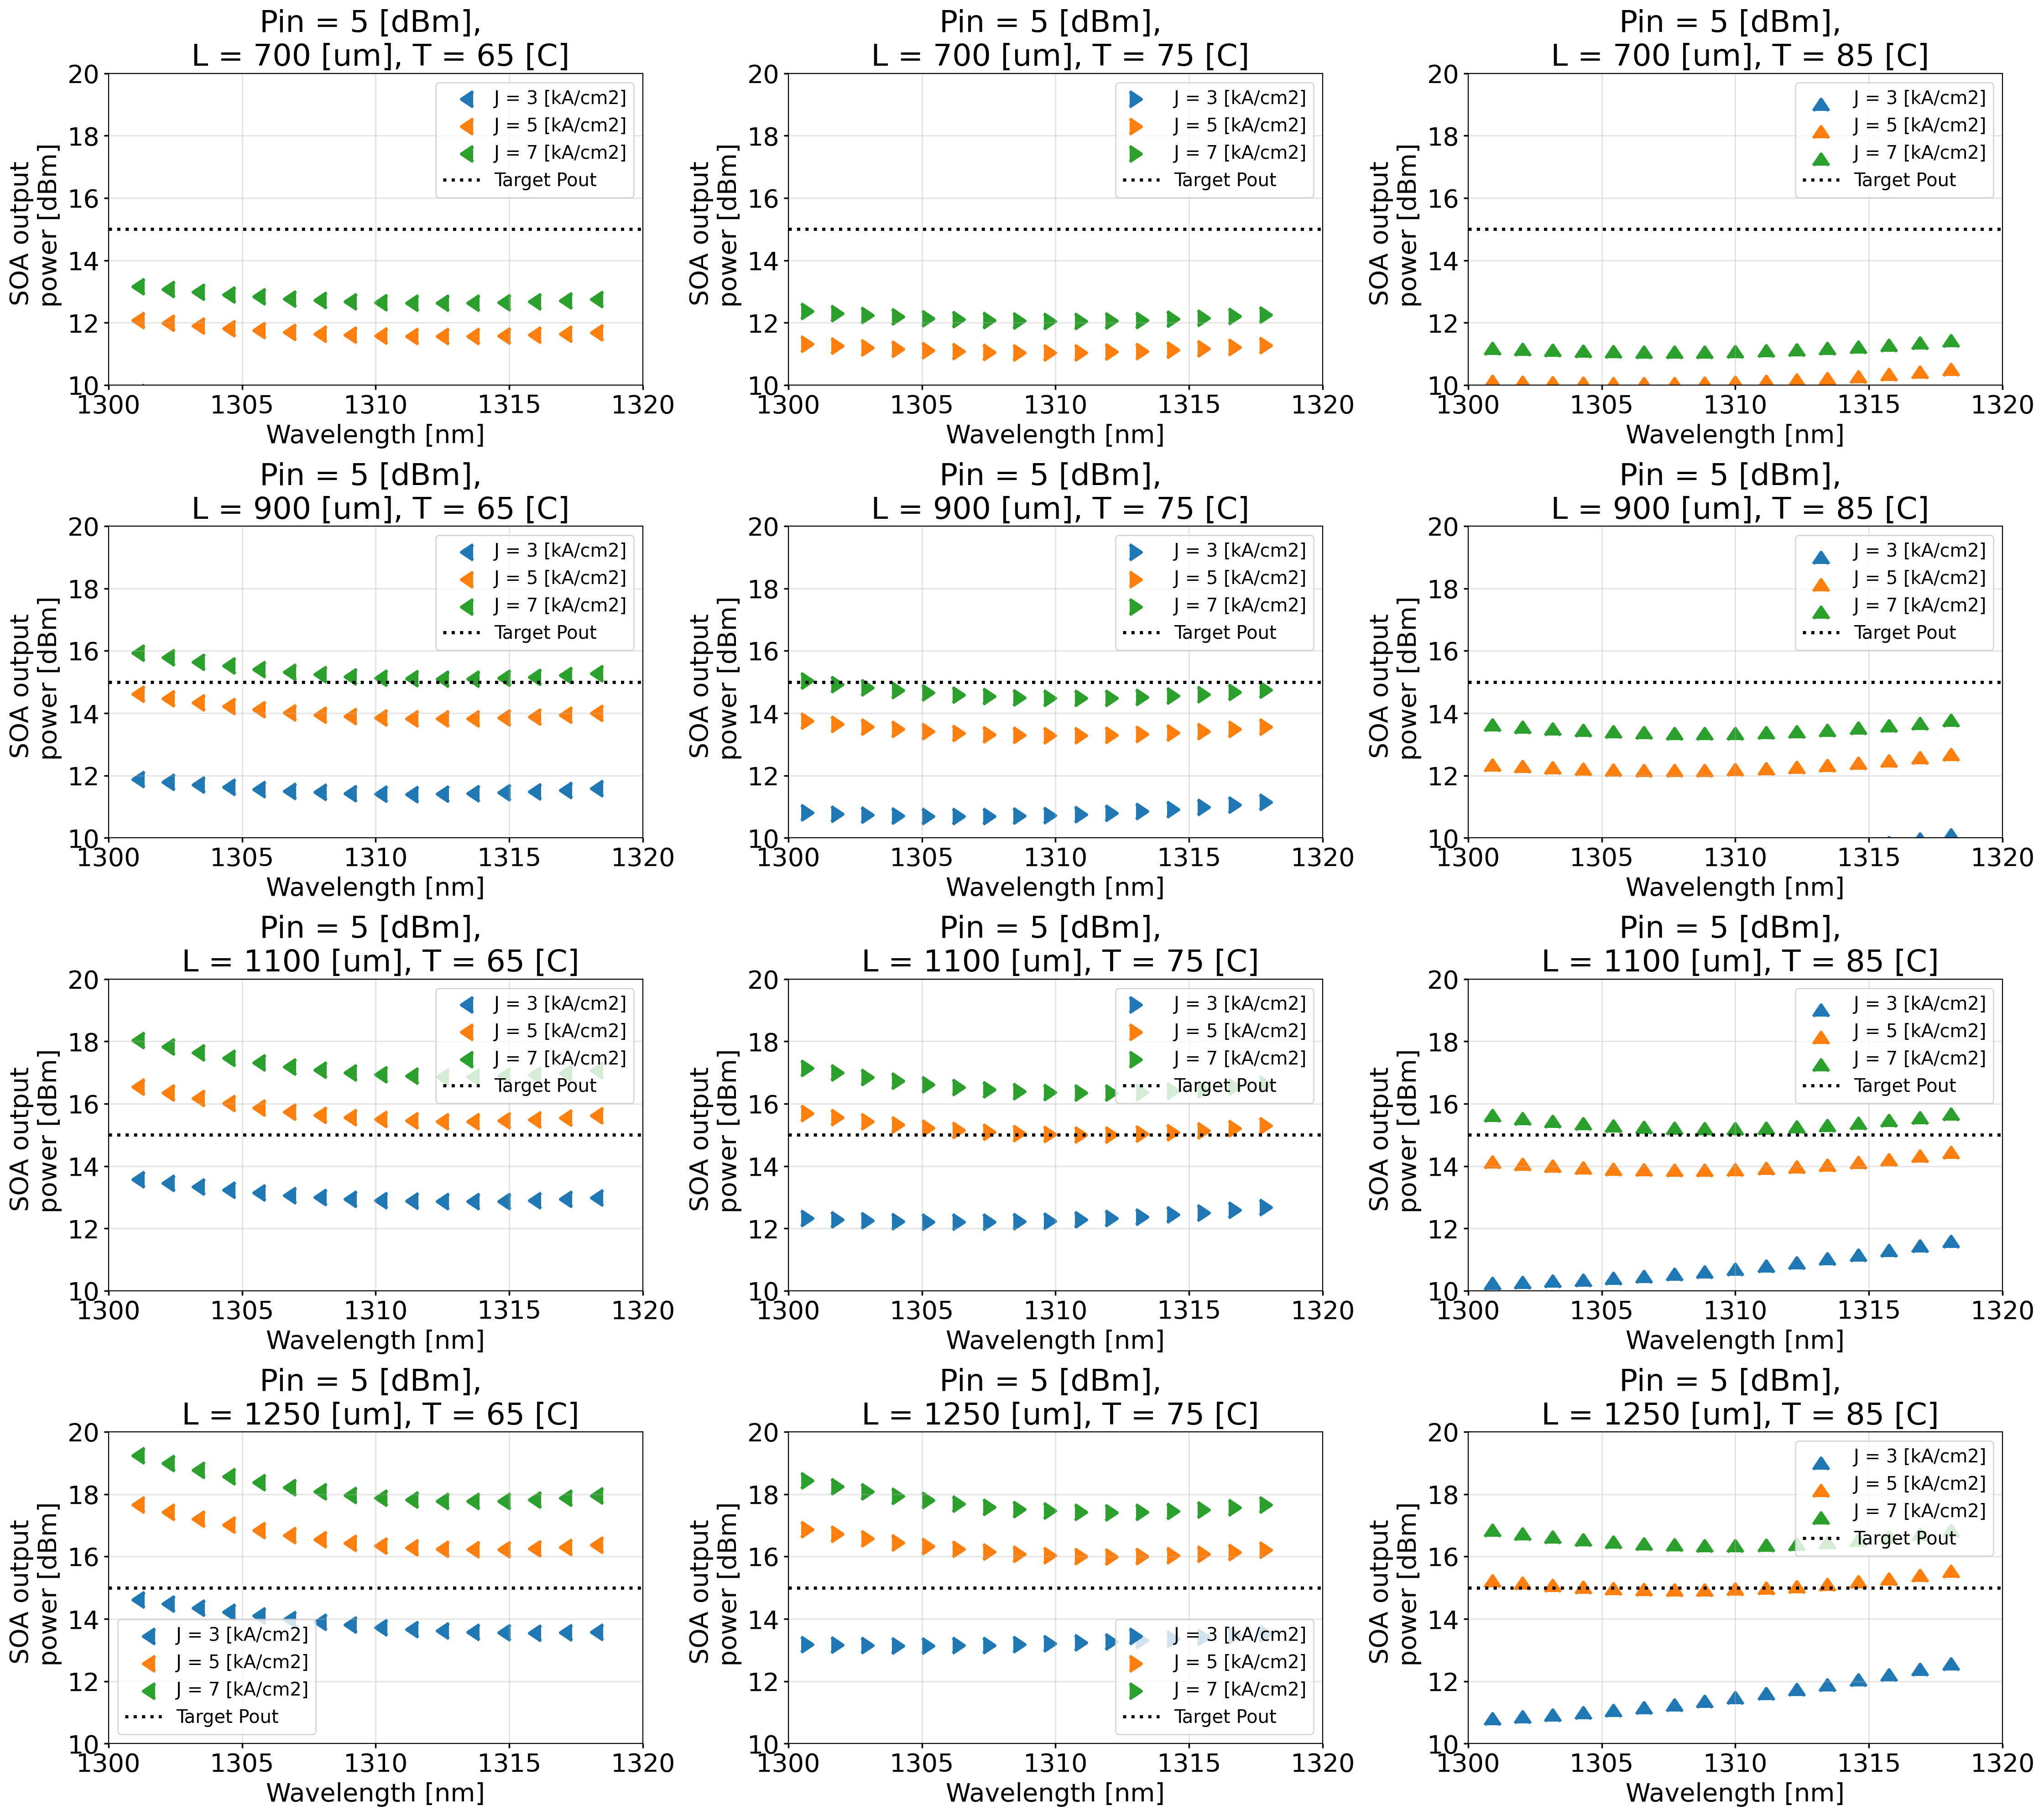

In [13]:
center_grid_wavelength = 1.31e-6
fsr = 400e9
grid_frequency_bank_A = [constants.c/center_grid_wavelength + i*fsr for i in range(-3, 5)]
grid_frequency_bank_B = [constants.c/center_grid_wavelength + (i-0.5)*fsr for i in range(-3, 5)]
grid_wavelength_bank_A = constants.c/np.array(grid_frequency_bank_A)
grid_wavelength_bank_B = constants.c/np.array(grid_frequency_bank_B) 

grid_wavelength_bank = np.sort(np.concatenate((grid_wavelength_bank_A, grid_wavelength_bank_B)))

L = np.array([240, 440, 640, 790])
J = np.array([3, 5,  7])
T = np.array([65, 75, 85])

# Pin = 0.003

plt.figure(figsize=(7.5*len(T),5*len(L)))

for idd_length, length in enumerate(L):
  for idd_temperature, temperature in enumerate(T):
    for idd_current_density, current_density in enumerate(J):
      gain, Pout, Psat = [], [], []
      for wavelength in grid_wavelength_bank:
        _soa = SOA(
          temperature = T[idd_temperature],
          current_density = J[idd_current_density],
          length = L[idd_length] * um,
        )
        sim().wavelength = wavelength
        _soa.recursive_update()
        _smatrix = _soa.smatrix
        gain.append(_soa._g0)
        Pout.append(_soa._output_power)
        Psat.append(_soa._Psat)

      plt.subplot(len(L),len(T),idd_length*len(T) + idd_temperature + 1)
      plt.scatter(grid_wavelength_bank/um*1000, np.array(Pout), marker = idd_temperature + 4, s = 150, label=f"J = {current_density} [kA/cm2]")

    plt.subplot(len(L),len(T),idd_length*len(T) + idd_temperature + 1)
    plt.plot(np.linspace(1300, 1320, num=100), np.ones(100)*15, linestyle=':', c='k', label="Target Pout")
    plt.legend()
    plt.xlim([1300, 1320])
    plt.xticks(np.arange(1300, 1325, 5))
    plt.ylim([10, 20])
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("SOA output \n power [dBm]")
    plt.title(f"Pin = 5 [dBm], \n L = {length + 460} [um], T = {temperature} [C]")
    plt.grid(True)
plt.tight_layout()


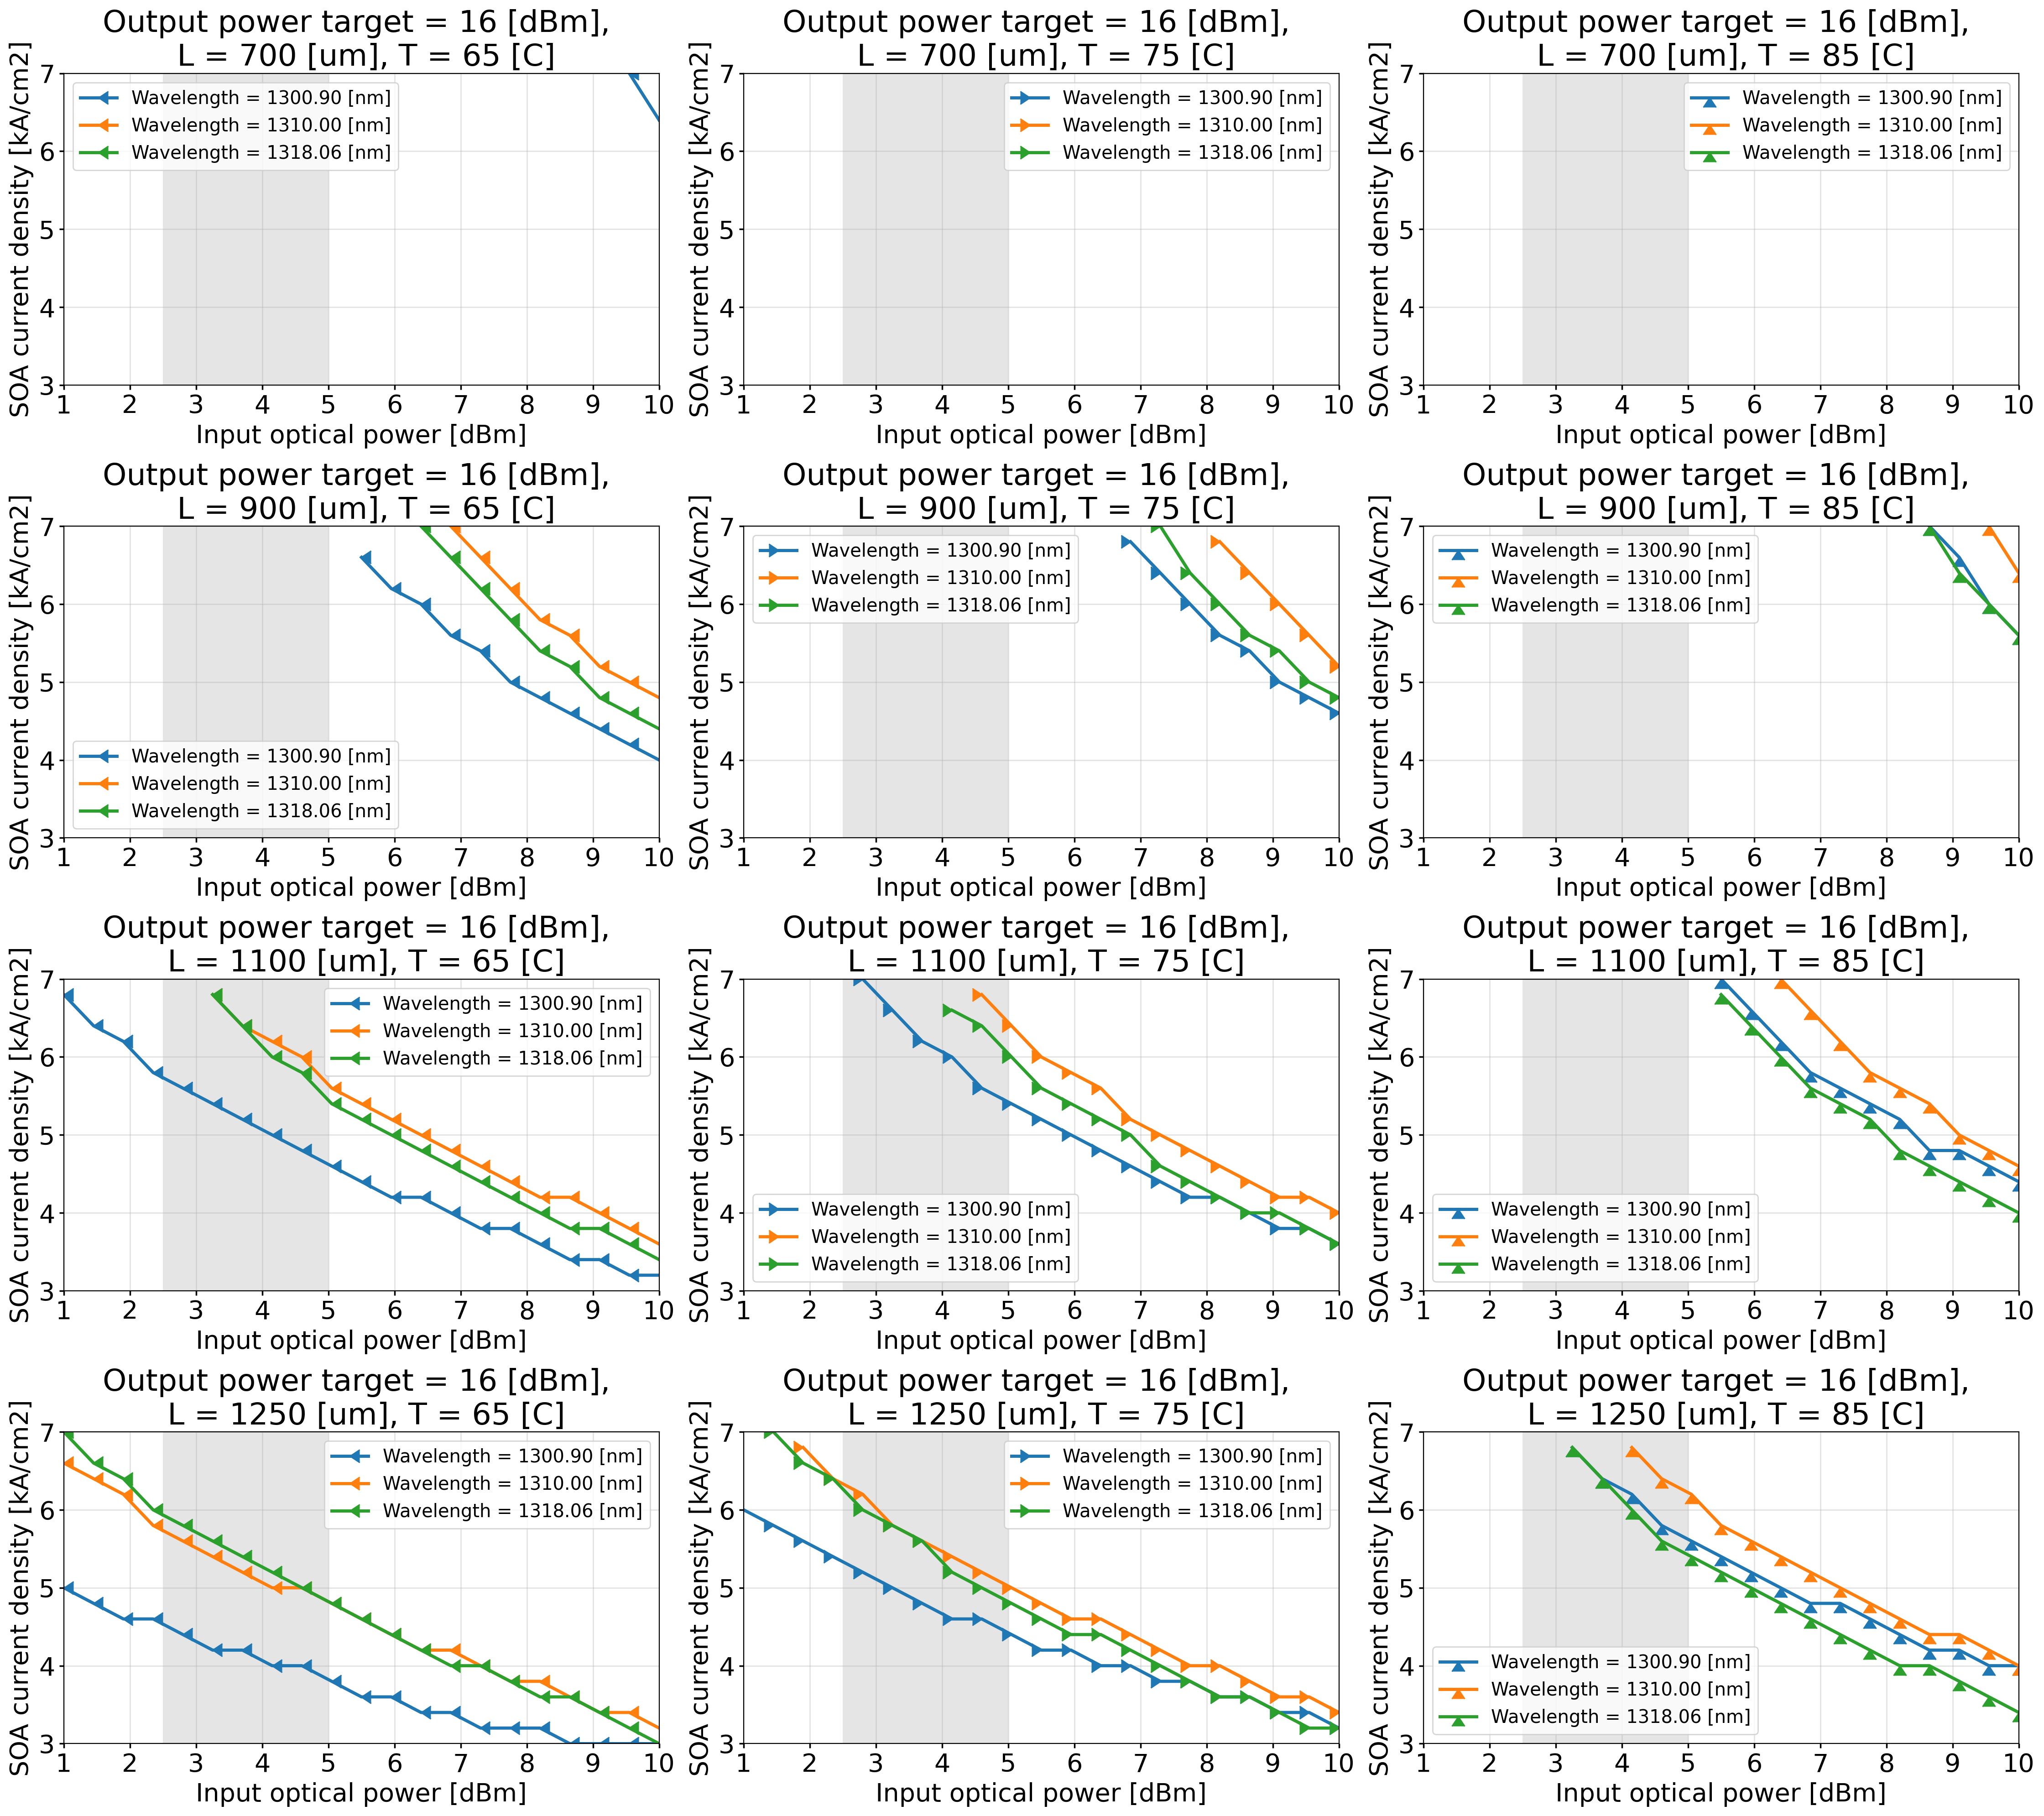

In [14]:
center_grid_wavelength = 1.31e-6
fsr = 400e9
grid_frequency_bank_A = [constants.c/center_grid_wavelength + i*fsr for i in range(-3, 5)]
grid_frequency_bank_B = [constants.c/center_grid_wavelength + (i-0.5)*fsr for i in range(-3, 5)]
grid_wavelength_bank_A = constants.c/np.array(grid_frequency_bank_A)
grid_wavelength_bank_B = constants.c/np.array(grid_frequency_bank_B) 

grid_wavelength_bank = np.sort(np.concatenate((grid_wavelength_bank_A, grid_wavelength_bank_B)))

grid_wavelength_focus = np.array([grid_wavelength_bank[0], grid_wavelength_bank[8], grid_wavelength_bank[-1]])

L = np.array([240, 440, 640, 790])
J = np.linspace(3, 7, num=21)
T = np.array([65, 75, 85])
Pin = np.linspace(1, 10, num=21)

_output_power_target = 16

plt.figure(figsize=(7.5*len(T),5*len(L)))
for idd_length, length in enumerate(L):
  for idd_temperature, temperature in enumerate(T):
    ax = plt.subplot(len(L),len(T),idd_length*len(T) + idd_temperature + 1)
    for wavelength in grid_wavelength_focus:
      pin_storage, j_storage = [], []
      for idd_pin, pin in enumerate(Pin):
        for idd_current_density, current_density in enumerate(J):
          _soa = SOA(
            temperature = T[idd_temperature],
            input_power=pin,
            current_density = J[idd_current_density],
            length = L[idd_length] * um,
          )
          sim().wavelength = wavelength
          _soa.recursive_update()
          _smatrix = _soa.smatrix

          _Pout = _soa._output_power

          if _Pout > _output_power_target:
            pin_storage.append(pin)
            j_storage.append(current_density)
            break

      plt.plot(pin_storage, np.array(j_storage), marker = idd_temperature + 4, label=f"Wavelength = {wavelength/um*1000:0.2f} [nm]")
    plt.axvspan(2.5, 5, color='black', alpha=0.1, lw=0)
    plt.legend()
    plt.xlim([1,10])
    plt.xticks(np.arange(1, 11, 1))
    plt.ylim([3, 7])
    plt.yticks(np.arange(3, 8, 1))
    plt.xlabel("Input optical power [dBm]")
    plt.ylabel("SOA current density [kA/cm2]")
    plt.title(f"Output power target = {_output_power_target} [dBm], \n L = {length + 460} [um], T = {temperature} [C]")
    plt.grid(True)
plt.tight_layout()


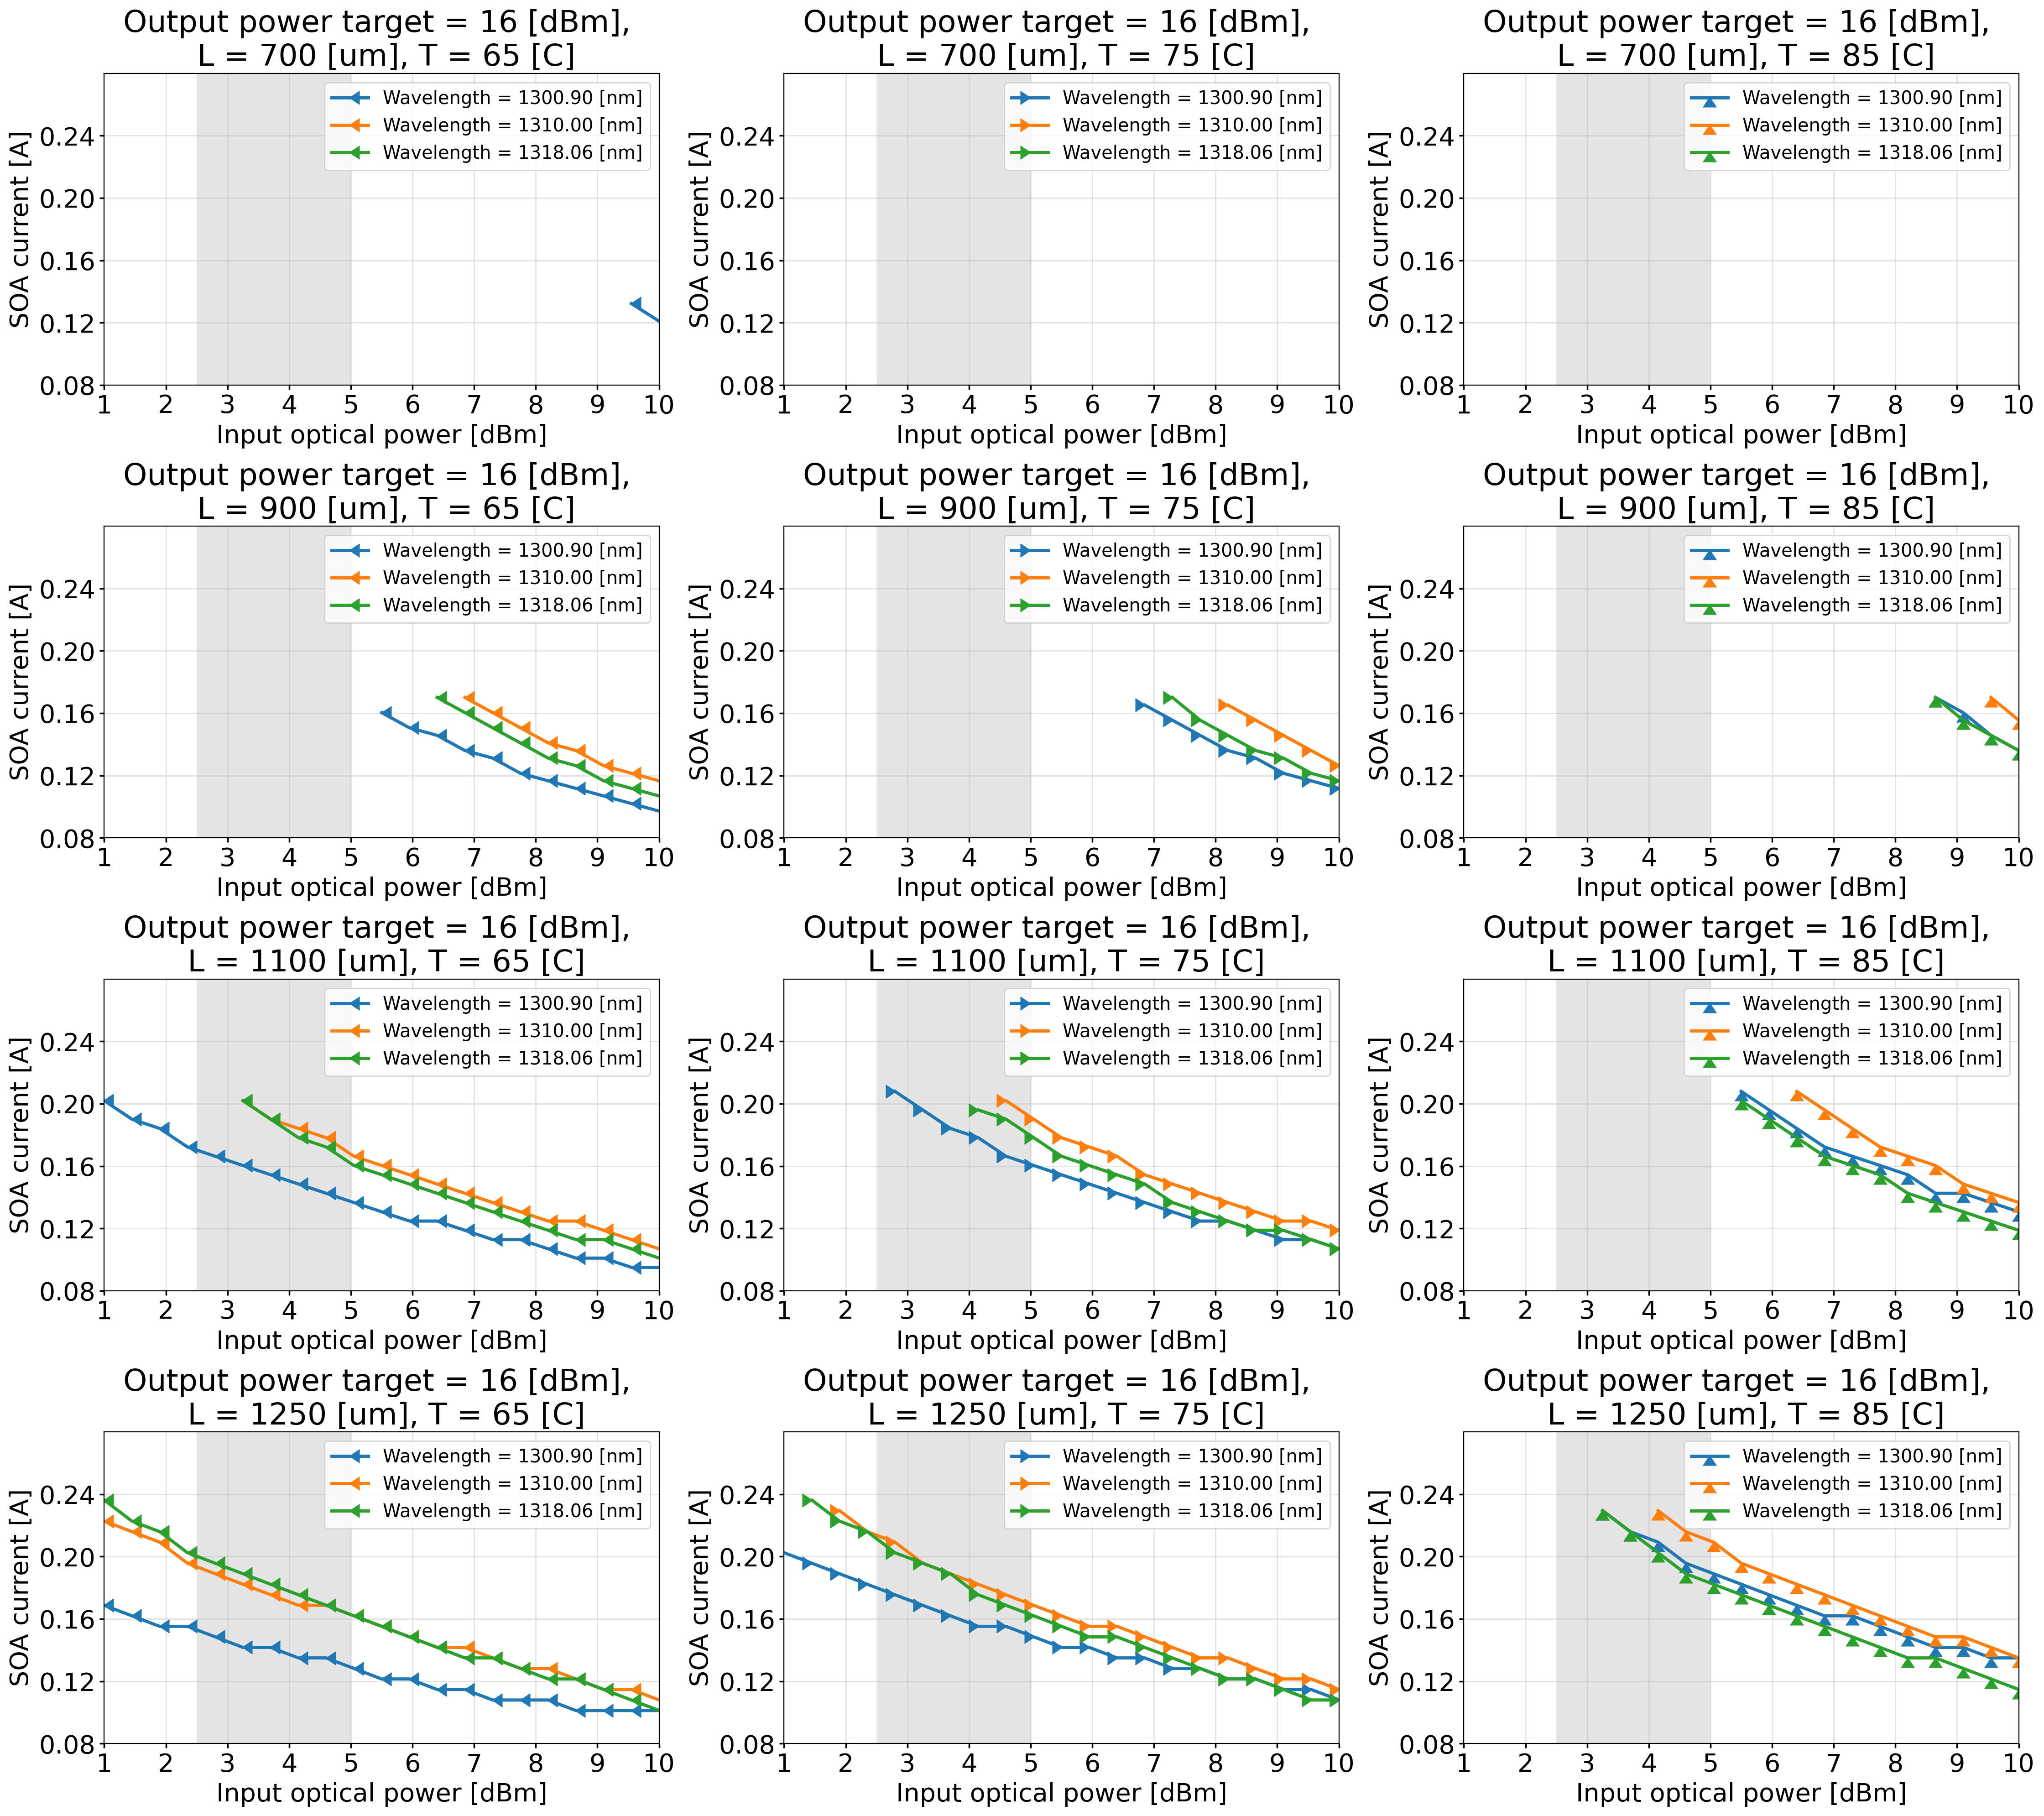

In [15]:
center_grid_wavelength = 1.31e-6
fsr = 400e9
grid_frequency_bank_A = [constants.c/center_grid_wavelength + i*fsr for i in range(-3, 5)]
grid_frequency_bank_B = [constants.c/center_grid_wavelength + (i-0.5)*fsr for i in range(-3, 5)]
grid_wavelength_bank_A = constants.c/np.array(grid_frequency_bank_A)
grid_wavelength_bank_B = constants.c/np.array(grid_frequency_bank_B) 

grid_wavelength_bank = np.sort(np.concatenate((grid_wavelength_bank_A, grid_wavelength_bank_B)))

grid_wavelength_focus = np.array([grid_wavelength_bank[0], grid_wavelength_bank[8], grid_wavelength_bank[-1]])

L = np.array([240, 440, 640, 790])
J = np.linspace(3, 7, num=21)
T = np.array([65, 75, 85])
Pin = np.linspace(1, 10, num=21)

_output_power_target = 16

plt.figure(figsize=(7.5*len(T),5*len(L)))
for idd_length, length in enumerate(L):
  for idd_temperature, temperature in enumerate(T):
    plt.subplot(len(L),len(T),idd_length*len(T) + idd_temperature + 1)
    for wavelength in grid_wavelength_focus:
      pin_storage, j_storage, i_storage = [], [], []
      for idd_pin, pin in enumerate(Pin):
        for idd_current_density, current_density in enumerate(J):
          _soa = SOA(
            temperature = T[idd_temperature],
            input_power=pin,
            current_density = J[idd_current_density],
            length = L[idd_length] * um,
          )
          sim().wavelength = wavelength
          _soa.recursive_update()
          _smatrix = _soa.smatrix
          _soa._vdiode()

          _Pout = _soa._output_power
          

          if _Pout > _output_power_target:
            pin_storage.append(pin)
            j_storage.append(current_density)
            i_storage.append(_soa._i_diode)
            break

      plt.plot(pin_storage, np.array(i_storage), marker = idd_temperature + 4, label=f"Wavelength = {wavelength/um*1000:0.2f} [nm]")
    plt.axvspan(2.5, 5, color='black', alpha=0.1, lw=0)
    plt.legend()
    plt.xlim([1,10])
    plt.xticks(np.arange(1, 11, 1))
    plt.ylim([0.08, 0.28])
    plt.yticks(np.arange(0.08, 0.28, 0.04))
    plt.xlabel("Input optical power [dBm]")
    plt.ylabel("SOA current [A]")
    plt.title(f"Output power target = {_output_power_target} [dBm], \n L = {length + 460} [um], T = {temperature} [C]")
    plt.grid(True)
plt.tight_layout()


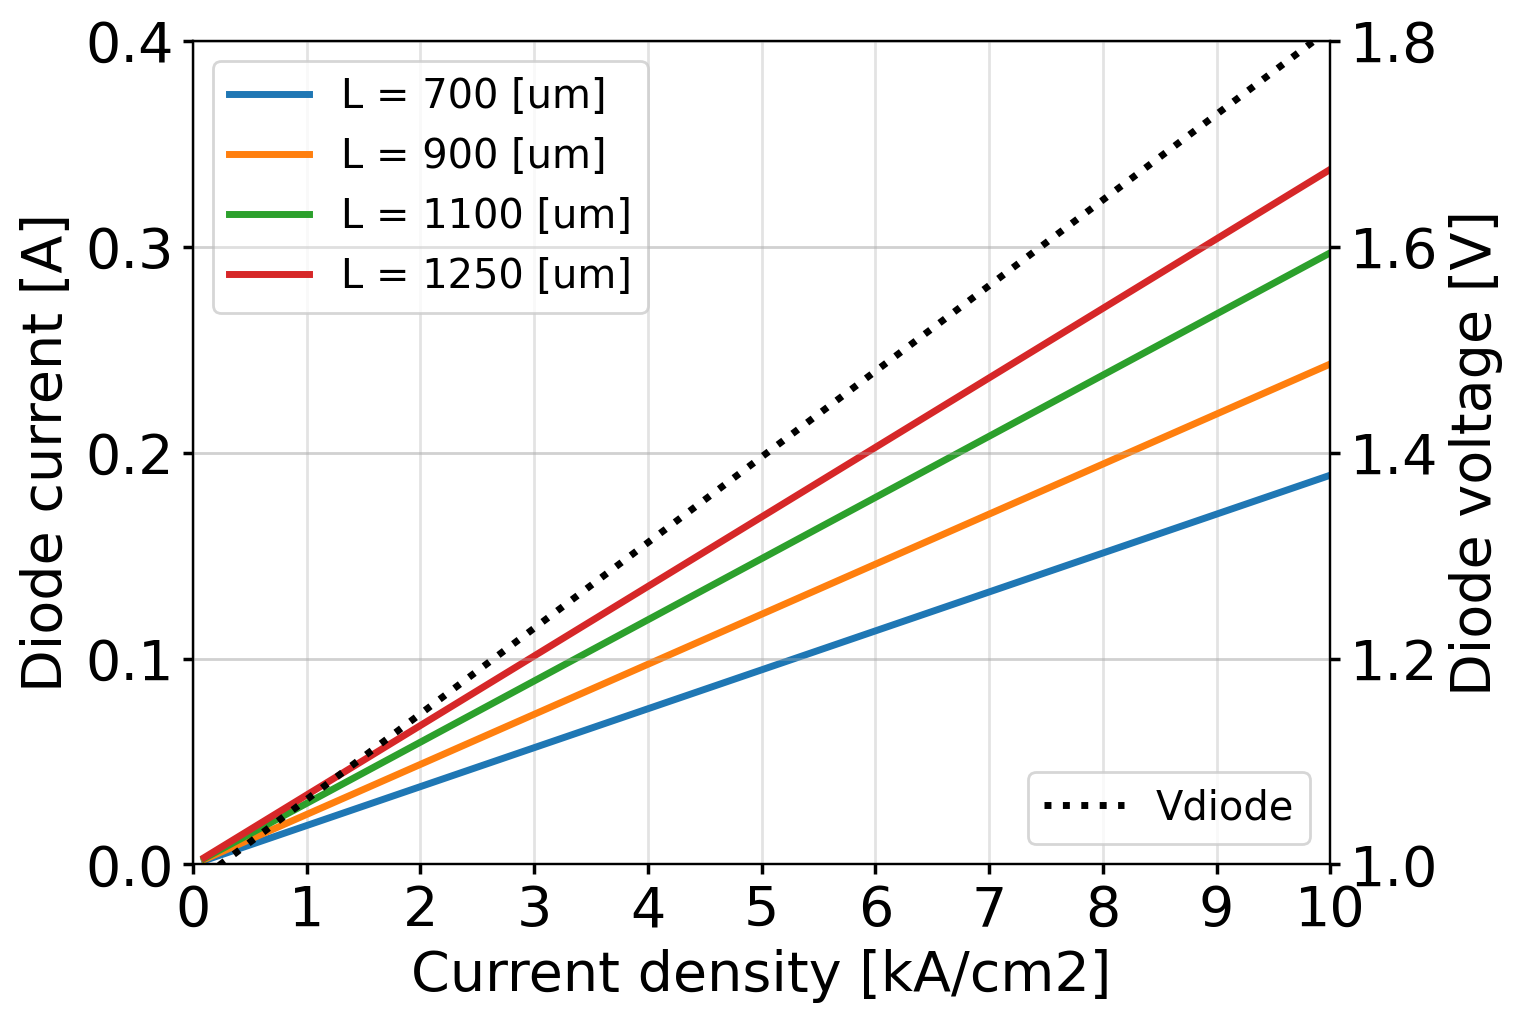

In [16]:
L = np.array([240, 440, 640, 790])
J = np.linspace(0.1, 10, num=101)

plt.figure(figsize=(7.5,5))
ax = plt.subplot(111)
for length in L:
  _vdiode, _idiode = [], []
  for current_density in J:
    _soa = SOA(
      temperature = 75,
      current_density = current_density,
      length = length * um,
    )
    sim().wavelength = 1.31e-6
    _soa._vdiode()
    _idiode.append(_soa._i_diode)
    _vdiode.append(_soa._v_diode)
  ax.plot(J, _idiode, label=f"L = {length + 460} [um]")
plt.legend(loc=2)
ax2 = ax.twinx()

ax2.plot(J, _vdiode[0:len(J)], linestyle=':', c='k', label=f"Vdiode")
plt.legend(loc=4)
ax.set_xlabel("Current density [kA/cm2]")
ax.set_ylim([0,0.4])
ax.set_xlim([0,10])
ax.set_xticks(np.arange(0, 11, 1))
ax.set_ylabel("Diode current [A]")
ax2.set_ylabel("Diode voltage [V]")
ax2.set_ylim([1.0,1.8])
ax2.set_xlim([0,10])
ax2.set_xticks(np.arange(0, 11, 1))
plt.grid(True)

## Heater

In [17]:
_ph_ht_tr = ph_ht_tr()
sim().wavelength = 1.31e-6
no_bias = np.angle(_ph_ht_tr.smatrix)[0,1]

_ph_ht_tr.dmW = 43
_ph_ht_tr.recursive_update()
_biased = np.angle(_ph_ht_tr.smatrix)[0,1]

print(f"Phase shift: {(_biased - no_bias)/np.pi:0.3f} [pi]")

Phase shift: 1.014 [pi]
